In [17]:
#Importing all Packages
import collections
import sys
import time
import cv2
import numpy as np
from pathlib import Path
from IPython import display
from openvino.runtime import Core
import notebook_utils as utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import torch.onnx
import gdown
sys.path.append("../utils")

### Explain about the the model building 

In [18]:
class VGGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights=True).features
        self.slice1 = vgg[: 2]
        self.slice2 = vgg[2: 7]
        self.slice3 = vgg[7: 12]
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, images):
        h1 = self.slice1(images)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        return h3
class RC(nn.Module):
    """A wrapper of ReflectionPad2d and Conv2d"""
    def __init__(self, in_channels, out_channels, kernel_size=3, pad_size=1, activated=True):
        super().__init__()
        self.pad = nn.ReflectionPad2d((pad_size, pad_size, pad_size, pad_size))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.activated = activated

    def forward(self, x):
        h = self.pad(x)
        h = self.conv(h)
        if self.activated:
            return F.relu(h)
        else:
            return h


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.rc1 = RC(256, 128, 3, 1)
        self.rc2 = RC(128, 128, 3, 1)
        self.rc3 = RC(128, 64, 3, 1)
        self.rc4 = RC(64, 64, 3, 1)
        self.rc5 = RC(64, 3, 3, 1, False)

    def forward(self, features):
        h = self.rc1(features)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc2(h)
        h = self.rc3(h)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc4(h)
        h = self.rc5(h)
        return h


In [3]:
# Downloading Model
#model_link = 'https://drive.google.com/file/d/1y5OC3KjKl8oZP1VdL9k4Y_NcFNmB9jhv/view?usp=share_link'
file_id = '1y5OC3KjKl8oZP1VdL9k4Y_NcFNmB9jhv'
file_url = 'https://drive.google.com/uc?id=' + file_id
!mkdir model
output_path = 'model'
gdown.download(file_url, output_path, quiet=False)

A subdirectory or file model already exists.
Downloading...
From: https://drive.google.com/uc?id=1y5OC3KjKl8oZP1VdL9k4Y_NcFNmB9jhv
To: C:\Users\mgcs1\OneDrive\Desktop\Py\model
100%|████████████████████████████████████████████████████████████████████████████████████████| 2.22M/2.22M [00:01<00:00, 1.83MB/s]


'model'

### Loading weights from ```model_state.pth``` to Decoder

In [19]:
decoder = Decoder()
decoder.load_state_dict(torch.load('model/modelq2lqqavftmp', map_location = 'cpu'))
decoder.eval()

Decoder(
  (rc1): RC(
    (pad): ReflectionPad2d((1, 1, 1, 1))
    (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (rc2): RC(
    (pad): ReflectionPad2d((1, 1, 1, 1))
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (rc3): RC(
    (pad): ReflectionPad2d((1, 1, 1, 1))
    (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (rc4): RC(
    (pad): ReflectionPad2d((1, 1, 1, 1))
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (rc5): RC(
    (pad): ReflectionPad2d((1, 1, 1, 1))
    (conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1))
  )
)

#### combining Encoder and Decoder with Sequential api

In [20]:
model = nn.Sequential(
    VGGEncoder(),
    decoder
)

In [21]:
model.eval()

Sequential(
  (0): VGGEncoder(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (1): Decoder(
    (rc1): RC(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (rc2):

In [22]:
# Define an example input to the model
from torch.fx import symbolic_trace
example_input = torch.randn(1, 3, 256, 256)
traced_model = symbolic_trace(model)
# Export the model to ONNX format
torch.onnx.export(traced_model, example_input, "model.onnx", verbose= True)
print("---- Completed exporting ----")

---- Completed exporting ----


In [23]:
# Converting from ONNX Format to Openvino 
!mo --input_model model.onnx --compress_to_fp16

[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: C:\Users\mgcs1\OneDrive\Desktop\Py\model.xml
[ SUCCESS ] BIN file: C:\Users\mgcs1\OneDrive\Desktop\Py\model.bin


In [9]:
# Converted IR model path
ir_path = Path(f"model.xml")
onnx_path = Path(f"model.bin")

In [10]:
# Initialize OpenVINO Runtime.
ie_core = Core()

# Read the network and corresponding weights from ONNX Model.
# model = ie_core.read_model(model=onnx_path)

# Read the network and corresponding weights from IR Model.
model = ie_core.read_model(model=ir_path)

# Compile the model for CPU (or change to GPU, MYRIAD etc. for other devices)
# or let OpenVINO select the best available device with AUTO.
compiled_model = ie_core.compile_model(model=model, device_name="AUTO")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [11]:
print(input_layer.any_name, output_layer.any_name)
print(input_layer.shape)
print(output_layer.shape)

# Get the input size.
N, C, H, W = list(input_layer.shape)


input.1 162
[1,3,256,256]
[1,3,256,256]


In [12]:
# Preprocess the input image.
def preprocess_images(frame, H, W):
    """
    Preprocess input image to align with network size

    Parameters:
        :param frame:  input frame 
        :param H:  height of the frame to style transfer model
        :param W:  width of the frame to style transfer model
        :returns: resized and transposed frame
    """
    image = np.array(frame).astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(src=image, dsize=(H, W), interpolation=cv2.INTER_AREA)
    image = np.transpose(image, [2, 0, 1])
    image = np.expand_dims(image, axis=0)
    return image

In [13]:
# Postprocess the result        
def convert_result_to_image(frame, stylized_image) -> np.ndarray:
    """
    Postprocess stylized image for visualization

    Parameters:
        :param frame:  input frame 
        :param stylized_image:  stylized image with specific style applied
        :returns: resized stylized image for visualization
    """
    h, w = frame.shape[:2]
    stylized_image = stylized_image.squeeze().transpose(1, 2, 0)
    stylized_image = cv2.resize(src=stylized_image, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    stylized_image = np.clip(stylized_image, 0, 255).astype(np.uint8)
    stylized_image = cv2.cvtColor(stylized_image, cv2.COLOR_BGR2RGB)
    return stylized_image

In [14]:
def run_style_transfer(source=0, flip=False, use_popup=False, skip_first_frames=0):
    """
    Main function to run the style inference:
    1. Create a video player to play with target fps (utils.VideoPlayer).
    2. Prepare a set of frames for style transfer.
    3. Run AI inference for style transfer.
    4. Visualize the results.
    Parameters:
        source: The webcam number to feed the video stream with primary webcam set to "0", or the video path.  
        flip: To be used by VideoPlayer function for flipping capture image.
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video. 
    """
    # Create a video player to play with target fps.
    player = None
    try:
        player = utils.VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start video capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 720 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(src=frame, dsize=None, fx=scale, fy=scale,
                                   interpolation=cv2.INTER_AREA)
            # Preprocess the input image.

            image = preprocess_images(frame, H, W)
           
            # Measure processing time for the input image.
            start_time = time.time()
            # Perform the inference step.
            stylized_image = compiled_model([image])[output_layer]
            stop_time = time.time()

            # Postprocessing for stylized image.
            result_image = convert_result_to_image(frame, stylized_image)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()
            processing_time_det = np.mean(processing_times) * 1000

            # Visualize the results.
            f_height, f_width = frame.shape[:2]
            fps = 1000 / processing_time_det
            cv2.putText(result_image, text=f"Inference time: {processing_time_det:.1f}ms ({fps:.1f} FPS)", 
                        org=(20, 40),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=f_width / 1000,
                        color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, result_image)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", result_image, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

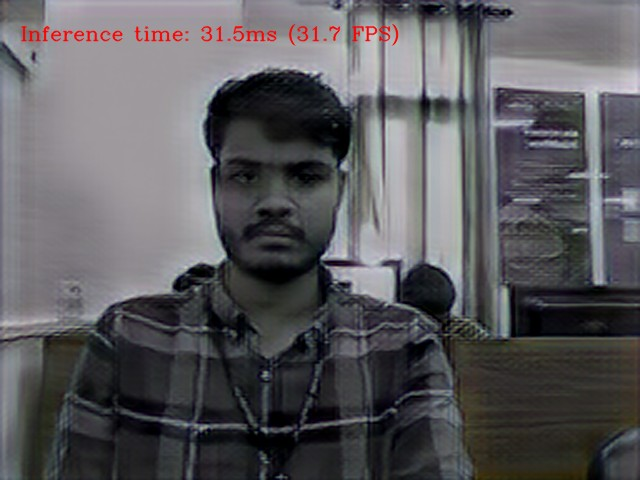

Interrupted


In [15]:
run_style_transfer(source=0, flip=True, use_popup=False)